## TensorFlow Reinforcement Learning -- Battleship
##### JSL September 2016

In [1]:
# 1.1 Import tensorflow and other libraries.
import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab

In [2]:
# 1.2 Define the nn variable network.
# Input is array of BOARD_SIZE values.
# ---------------------------------------
#  -1 value -> Not yet checked
#   0 value -> Checked, no ship
#   1 value -> Checked, is ship location.
# ---------------------------------------
BOARD_SIZE = 10
SHIP_SIZE = 3

hidden_units = BOARD_SIZE
output_units = BOARD_SIZE

input_positions = tf.placeholder(tf.float32, shape=(1, BOARD_SIZE))
labels =          tf.placeholder(tf.int64)
learning_rate =   tf.placeholder(tf.float32, shape=[])
# Generate hidden layer
W1 = tf.Variable(tf.truncated_normal([BOARD_SIZE, hidden_units],
             stddev=0.1 / np.sqrt(float(BOARD_SIZE))))
b1 = tf.Variable(tf.zeros([1, hidden_units]))
h1 = tf.tanh(tf.matmul(input_positions, W1) + b1)
# Second layer -- linear classifier for action logits
W2 = tf.Variable(tf.truncated_normal([hidden_units, output_units],
             stddev=0.1 / np.sqrt(float(hidden_units))))
b2 = tf.Variable(tf.zeros([1, output_units]))
logits = tf.matmul(h1, W2) + b2 
probabilities = tf.nn.softmax(logits) 

In [3]:
# 1.3 Define the operations we will use
init = tf.initialize_all_variables()
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
train_step = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(cross_entropy)
# Start TF session
sess = tf.Session()
sess.run(init)

In [16]:
# 1.4 Game play definition.
TRAINING = True
def play_game(training=TRAINING):
    """ Play game of battleship using network."""
    # Select random location for ship
    ship_left = np.random.randint(BOARD_SIZE - SHIP_SIZE + 1)
    ship_positions = set(range(ship_left, ship_left + SHIP_SIZE))
    # Initialize logs for game
    board_position_log = []
    action_log = []
    hit_log = []
    # Play through game
    current_board = [[-1 for i in range(BOARD_SIZE)]]
    while (sum(hit_log) < SHIP_SIZE) and (len(action_log) < BOARD_SIZE):
        board_position_log.append([[i for i in current_board[0]]])
        probs = sess.run([probabilities], feed_dict={input_positions:current_board})[0][0]
        probs = [p * (index not in action_log) for index, p in enumerate(probs)]
        probs = [p / sum(probs) for p in probs]
        if training == True:
            bomb_index = np.random.choice(BOARD_SIZE, p=probs)            
        else:
            bomb_index = np.argmax(probs)
        # update board, logs
        hit_log.append(1 * (bomb_index in ship_positions))
        current_board[0][bomb_index] = 1 * (bomb_index in ship_positions)
        action_log.append(bomb_index)
    return board_position_log, action_log, hit_log
# Example:
play_game()

([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
  [[-1, -1, 0, -1, -1, -1, -1, -1, -1, -1]],
  [[-1, -1, 0, -1, -1, 0, -1, -1, -1, -1]],
  [[-1, -1, 0, -1, -1, 0, 1, -1, -1, -1]],
  [[-1, -1, 0, -1, -1, 0, 1, 1, -1, -1]]],
 [2, 5, 6, 7, 8],
 [0, 0, 1, 1, 1])

In [11]:
# 1.5 Reward function definition
def rewards_calculator(hit_log, gamma=0.5):
    """ Discounted sum of future hits over trajectory"""            
    hit_log_weighted = [(item -  
                         float(SHIP_SIZE - sum(hit_log[:index])) / float(BOARD_SIZE - index)) * (
            gamma ** index) for index, item in enumerate(hit_log)]
    return [((gamma) ** (-i)) * sum(hit_log_weighted[i:]) for i in range(len(hit_log))]

# Example
rewards_calculator([0,0,1,1,1])

[-0.16904761904761903,
 0.2619047619047619,
 1.1904761904761905,
 1.130952380952381,
 0.8333333333333334]

In [18]:
# 1.6 Training loop: Play and learn
game_lengths = []
TRAINING = True   # Boolean specifies training mode
ALPHA = 0.06      # step size

for game in range(10000):
    board_position_log, action_log, hit_log = play_game(training=TRAINING)
    game_lengths.append(len(action_log))
    rewards_log = rewards_calculator(hit_log)
    for reward, current_board, action in zip(rewards_log, board_position_log, action_log):
        # Take step along gradient
        if TRAINING:
            sess.run([train_step], 
                feed_dict={input_positions:current_board, labels:[action], learning_rate:ALPHA * reward})

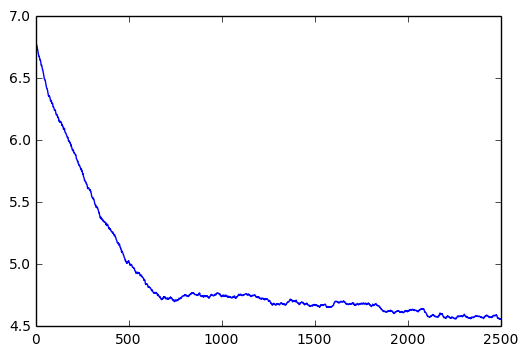

In [17]:
# 1.7 Plot running average game lengths
window_size = 500
running_average_length = [np.mean(game_lengths[i:i+window_size]) for i in range(len(game_lengths)- window_size)]
pylab.plot(running_average_length)

In [26]:
# 1.8 Example showing how to print current coefficient values
sess.run([W1], 
             feed_dict={input_positions:board_position_log[0]})

[array([[ 0.36417413,  0.21842285, -1.05438769,  0.92670012, -0.971443  ,
         -0.42181543, -0.12549876, -0.1459792 ,  1.37149823,  0.88486165],
        [ 0.40269327, -2.3138361 , -1.52807772, -1.89444983,  1.6621691 ,
          1.21897411, -0.59128791,  0.32018194,  0.12851822, -1.5733639 ],
        [ 0.75337362,  1.18250155,  1.49976432,  2.45021749, -2.0455699 ,
         -1.00975513, -3.52385998, -2.81726122, -1.13073385,  0.09371365],
        [-2.73572493, -2.58016634, -2.54336786,  0.78801006, -1.01746631,
          0.83182812, -0.28737754,  0.25912744, -0.71347362,  5.37003899],
        [-0.85589498,  1.38819838,  3.10451198, -3.52761793, -2.22771525,
         -0.35671455,  2.07410955, -1.88416684, -1.69944739, -0.94166577],
        [ 1.26362193, -1.74665356, -0.12891544,  0.56791085,  2.06429219,
         -1.82320964, -1.02321613,  2.33585477,  0.26630208, -0.07931795],
        [-0.70836729,  1.72130585, -2.96304846, -0.78141487, -3.5275557 ,
          1.48491037,  0.2049609